In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW, 
    get_linear_schedule_with_warmup, 
    T5ForConditionalGeneration, 
    T5Tokenizer
)

In [2]:
# reference: https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb
pd.read_csv("emodata/train.txt", sep=";", header=None, names=["text", "emotion"]).head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
class EmoData(Dataset): 
    
    def __init__(self, tokenizer, data_path, max_len): 
        super().__init__()
        self.tokenizer = tokenizer
        self.df = pd.read_csv(data_path, sep=";", header=None, names=["text", "emotion"])
        self.max_len = max_len
        self.inputs, self.labels = self._build()
        
    def _build(self): 
        inputs = []
        labels = []
        for (_, (text, label)) in self.df.iterrows(): 
            inputs.append(
                self.tokenizer.batch_encode_plus(
                    [text], max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt"
                )
            )
            labels.append(
                self.tokenizer.batch_encode_plus(
                    [label], max_length=2, truncation=True, padding="max_length", return_tensors="pt"
                )
            )
        return inputs, labels
        
    def __len__(self): 
        return len(self.inputs)
    
    def __getitem__(self, idx): 
        input_ids = self.inputs[idx]["input_ids"].squeeze()
        input_mask = self.inputs[idx]["attention_mask"].squeeze()
        label_ids = self.labels[idx]["input_ids"].squeeze()
        label_mask = self.labels[idx]["attention_mask"].squeeze()
        return {
            "input_ids": input_ids, 
            "attention_mask": input_mask, 
            "labels": label_ids, 
            "decoder_attention_mask": label_mask
        }

In [4]:
def to_cuda(batch): 
    for (key, value) in batch.items(): 
        batch[key] = value.to("cuda")
    return batch

In [5]:
BATCH_SIZE = 128
EPOCHS = 2
MAX_LEN = 32

In [6]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

train_loader = DataLoader(
    dataset=EmoData(tokenizer, "emodata/train.txt", MAX_LEN), 
    batch_size=BATCH_SIZE, 
    drop_last=True, 
    shuffle=True, 
    num_workers=4
)

val_loader = DataLoader(
    dataset=EmoData(tokenizer, "emodata/val.txt", MAX_LEN), 
    batch_size=BATCH_SIZE, 
    num_workers=4
)

In [7]:
model = T5ForConditionalGeneration.from_pretrained("t5-base").to("cuda")
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
optimizer = AdamW(model.parameters(), lr=3e-4, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader))

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
train_loss = []

for epoch in range(EPOCHS): 
    # trian
    model.train()
    for batch in train_loader: 
        batch = to_cuda(batch)
        outputs = model(**batch)
        train_loss.append(
            torch.mean(outputs.loss.detach()).item()
        )
        optimizer.zero_grad()
        (torch.min(outputs.loss)).backward()
        optimizer.step()
        scheduler.step()
        if len(train_loss) > 0 and len(train_loss) % 10 == 0: 
            print("Epoch: {}, Train Step: {}, Loss: {}".format(epoch, len(train_loss), train_loss[-1]))
    # val
    model.eval()
    for batch in val_loader: 
        batch = to_cuda(batch)
        outputs = model(**batch)

/home/ubuntu/env/nlp/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch: 0, Train Step: 10, Loss: 1.2780022621154785
Epoch: 0, Train Step: 20, Loss: 0.7013925313949585
Epoch: 0, Train Step: 30, Loss: 0.7068116664886475
Epoch: 0, Train Step: 40, Loss: 0.6651327610015869
Epoch: 0, Train Step: 50, Loss: 0.5460911989212036
Epoch: 0, Train Step: 60, Loss: 0.5076332688331604
Epoch: 0, Train Step: 70, Loss: 0.3881429433822632
Epoch: 0, Train Step: 80, Loss: 0.38563859462738037
Epoch: 0, Train Step: 90, Loss: 0.34475940465927124
Epoch: 0, Train Step: 100, Loss: 0.45172032713890076
Epoch: 0, Train Step: 110, Loss: 0.5383156538009644
Epoch: 0, Train Step: 120, Loss: 0.3593895733356476
Epoch: 1, Train Step: 130, Loss: 0.4107598066329956
Epoch: 1, Train Step: 140, Loss: 0.36219507455825806
Epoch: 1, Train Step: 150, Loss: 0.41177570819854736
Epoch: 1, Train Step: 160, Loss: 0.4016815423965454
Epoch: 1, Train Step: 170, Loss: 0.44550901651382446
Epoch: 1, Train Step: 180, Loss: 0.400779664516449
Epoch: 1, Train Step: 190, Loss: 0.2989102602005005
Epoch: 1, Train 

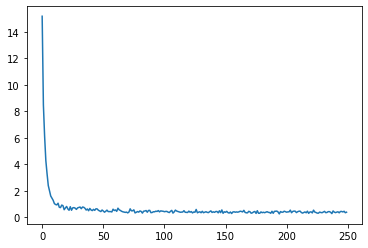

In [9]:
plt.plot(train_loss)

In [10]:
# test
test_loader = DataLoader(
    dataset=EmoData(tokenizer, "emodata/test.txt", MAX_LEN), 
    batch_size=32, 
    shuffle=True
)
batch = next(iter(test_loader))
batch = to_cuda(batch)

In [11]:
model.eval()
outputs = model.module.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], max_length=2)

In [12]:
for i in range(len(batch["input_ids"])): 
    print("text: {}".format(tokenizer.decode(batch["input_ids"][i, :])))
    print("Ground Truth: {}".format(tokenizer.decode(batch["labels"][i, :])))
    print("Output: {}".format(tokenizer.decode(outputs[i])))
    print("=====================================================================\n")

text: i can t help but feel really nostalgic of the disney levels</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth: love</s>
Output: <pad> love

text: i feel a little glamorous i wet the brush</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth: joy</s>
Output: <pad> joy

text: i am feeling sinfully horny this sunday morning</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth: love</s>
Output: <pad> anger

text: i feel truly heartbroken that hyun joongs fans can be so hateful</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth: sadness</s>
Output: <pad> sadness

text: i should stop reading sids blogs but it is part of my blogging community and i feel that in supporting each other we get better at handling</s>
Ground Truth: love</s>
Output: <pad> joy

text: i fe